# Darks Souls II Reviews (2023)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import re

## Steam Reviews as of 3/30/24:

In [2]:
df = pd.read_csv('reviews.csv')
reviews = df.copy()
reviews = reviews.set_index('recommendationid')
reviews.drop(columns={'Unnamed: 0', 'in_early_access'}, inplace=True)

Converting date of review from unix:

In [3]:
reviews['month'] = pd.to_datetime(reviews.update_date, unit='s').dt.month_name()
reviews['year'] = pd.to_datetime(reviews.update_date, unit='s').dt.year

Focusing on just the English reviews:

In [4]:
reviews = reviews[reviews.language == 'english']

## EDA:

Distribution of whether or not people recommend buying the game:

In [5]:
recommended_props = reviews[['voted_up']].value_counts(normalize=True).reset_index()

props = alt.Chart(recommended_props).mark_bar().encode(
    alt.X('voted_up', sort=[True, False], axis=alt.Axis(labelAngle=0)).title('Recommeneded'),
    alt.Y('proportion').title('Proportion'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False]),
).properties(
    width=500,
    height=300,
    title="Proportion of people who recommend playing DS2:Scholar of the First Sin (2015-2024)",
).configure_legend(
    titleFontSize=12,
    labelFontSize=12,
) 
props

alt.Chart(...)

- Most people actually recommend the game

Proportions of those who don't and do recommend DS2 in each of the years:

In [6]:
yr_props = reviews.groupby(['year', 'voted_up'])[['review']].count().reset_index()
yr_props['total_reviews'] = yr_props.groupby('year')['review'].transform('sum')
yr_props['proportion'] = yr_props['review'] / yr_props['total_reviews']

yr_count_dist_line = alt.Chart(yr_props).mark_line().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

yr_count_dist_bar = alt.Chart(yr_props).mark_bar().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

(
    (yr_count_dist_line & yr_count_dist_bar)
)

alt.VConcatChart(...)

- Contrary to popular belief, most people actually recommend playing the since its release back in 2015
- Game released    : April 2015 (Scholar of the First Sin edition)
- Amount of reviews during pandemic (2020-2023) was the highest amount for the game ever (at least on Steam exclusively)

## Cleaning up the reviews

- Removing anything that's not a letter (urls, esc seqs, etc.):

In [7]:
from nltk.corpus import stopwords

# Removing urls:
r = [re.sub(r'http\S+', '', review).lower().strip() if pd.notna(review) else review for review in reviews.review]

# Removing esc sequences, punctuation, and numbers:
    # There's some ASCII art in some of the reviews
r = [re.sub(r'[^A-Za-z]', ' ', review).strip() if pd.notna(review) else review for review in r]

# Removing stop words (may not be the best practice):
stop_wrds = re.compile(''.join([rf'\b{wrd}\b|' for wrd in stopwords.words('english')]))
r = [re.sub(stop_wrds, '', review).strip() if pd.notna(review) else review for review in r]

# Removing multiple and trailing whitespaces:
r = [re.sub(r' +', ' ', review).strip() if pd.notna(review) else review for review in r]

reviews['review'] = r

- Dealing with misspelled words (needed for proper topic modeling):
    - Typos won't get caught and removed in Stop word removal thus affecting efficiency of training process. This would severely affect accuracy of NLP, text or sentiment analysis and topic modelling tasks.
    - Common phrases within the souls community that are misspelled on purpose:
        - 'git gud' : 'get good'
        - 'casul' : 'casual' 

In [8]:
from textblob import TextBlob

from autocorrect import Speller
spell = Speller(lang='en')

In [9]:
reviews

,review,language,init_date,update_date,voted_up,month,year
recommendationid,,,,,,,
161822555,know dark souls gets lot hate personally think...,english,1711822731,1711822731,False,March,2024
161819114,expecting like original dissapointment overall...,english,1711819586,1711819586,True,March,2024
161818428,shit,english,1711819000,1711819000,False,March,2024
161816145,NaN,english,1711816954,1711816954,True,March,2024
161816097,genuinely bad,english,1711816908,1711816908,False,March,2024
...,...,...,...,...,...,...,...
15162268,try tongue hole,english,1427932431,1428081346,True,April,2015
15162220,far good played mins far problems k r gb gb dd...,english,1427932153,1427932153,True,April,2015
15162161,still died bonedrinker rufus keep streak alive,english,1427931845,1427931845,True,April,2015


## Sentiment Analysis:
- Seeing why people were positive or negative about the game
    - Comments on story, gameplay, etc

For sake of analysis specifically on the actual reviews, drop any rows that have no reviews:

In [10]:
reviews = reviews.dropna(subset=['review'])
reviews.shape

(39689, 7)

Top 10 Most Common Words in the Reviews:

In [11]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=4000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [13]:
review_txt = reviews.review.values.flatten()
tfidf_array = tfidf.fit_transform(review_txt).toarray()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df.columns = tfidf.get_feature_names_out()
tfidf_df.head()

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


,aaa,aava,abandoned,abilities,ability,able,absolute,absolutely,absurd,abundance,...,youre,youtube,z,zallen,zelda,zero,zombie,zombies,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
most_unique = tfidf_df.idxmax(axis=1)
top_10 = most_unique.value_counts()[:10]
top_10

aaa      1708
good      910
best      479
yes       372
dark      275
great     245
nice      237
git       221
gud       217
bad       206
Name: count, dtype: int64

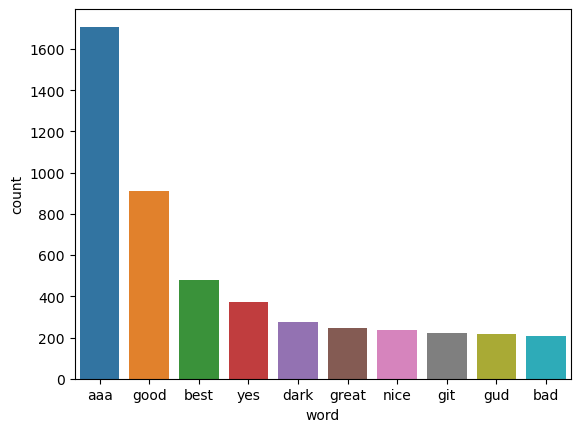

In [15]:
top_10 = top_10.reset_index()
top_10.rename(columns={'index':'word'}, inplace=True)
sns.barplot(data=top_10,
            x='word',
            y='count');

- Most popular word w/ semantic meaning: Triple A 
    - def: an informal classification used to classify video games produced and distributed by a mid-sized or major publisher
- Top words used seem to be positive, but this is looking at the words without context

Other popular words:

In [16]:
from wordcloud import WordCloud

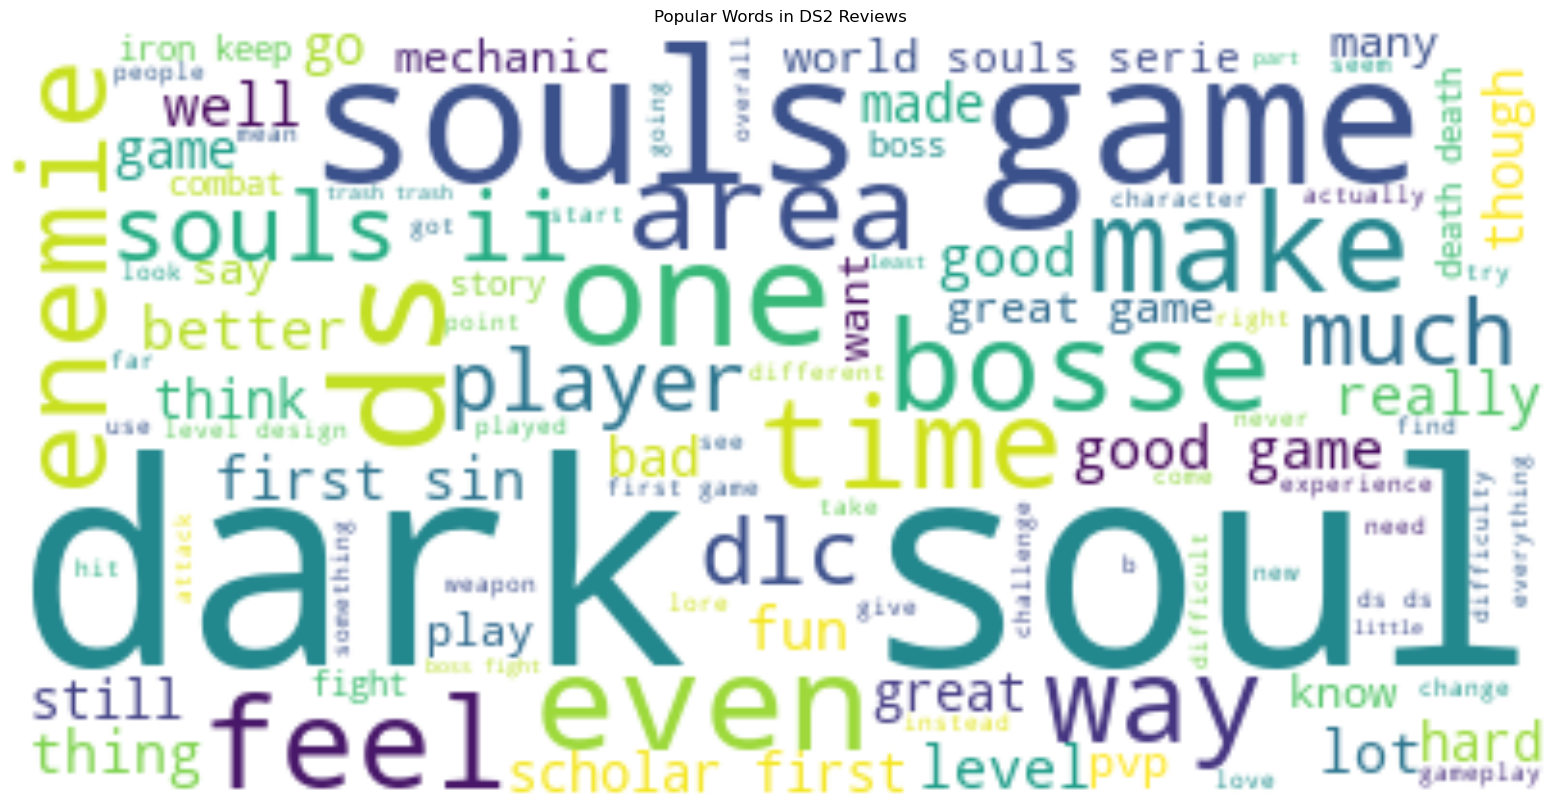

In [17]:
pop_wrds = " ".join( review for review in reviews.review)
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white").generate( pop_wrds )
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.title('Popular Words in DS2 Reviews')
plt.show()

- Most common word among the reviews isn't very informative - including some of the other popular words
    - Looking at subsets of the reviews could be useful

### Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews
    
- Algorithms I can use to perform topic modeling:
    1. Latent Dirichlet Allocation (LDA) 
    2. Non-negative Matrix Factorization (NMF)

Splitting the reviews by how many do and don't recommend buying the game:

In [18]:
pos_reviews = reviews[reviews['voted_up'] == True]
neg_reviews = reviews[reviews['voted_up'] == False]

In [19]:
pos_reviews.shape, neg_reviews.shape

((32589, 7), (7100, 7))

Function to display the output of the models:

In [20]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx + 1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx + 1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

LDA: Probabilistic graphical modeling, and uses CountVectorizer as input

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

In [22]:
count_vector = CountVectorizer()

tf = count_vector.fit_transform(reviews.review).toarray()
tf_feat_names = count_vector.get_feature_names_out()

pos_tf = count_vector.fit_transform(pos_reviews.review).toarray()
pos_tf_feat_names = count_vector.get_feature_names_out()

neg_tf = count_vector.fit_transform(neg_reviews.review).toarray()
neg_tf_feat_names = count_vector.get_feature_names_out()

In [23]:
lda = LatentDirichletAllocation(n_components=3, random_state=42069)
lda.fit(tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [24]:
no_top_words = 10
display_topics(lda, tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,27306.3,game,3078.3,game,21039.9
1,game,27108.8,death,1675.3,ds,6916.3
2,dark,20031.0,good,1299.6,like,6349.5
3,first,6568.5,hate,1244.5,get,4707.5
4,ds,5624.7,die,972.8,good,4219.8
5,still,5343.5,gud,949.4,enemies,4189.1
6,games,5331.0,shit,919.6,even,3804.7
7,like,5250.4,fucking,842.5,play,3597.1
8,one,5127.1,died,829.1,one,3375.5
9,good,4906.6,rolin,726.3,time,3374.7


- Interpreted topics that were identified:
    1. People saying how good the game is
    2. Bosses/enemies
    3. People expressing their likes or dislikes of the game

In [25]:
pos_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
pos_lda.fit(pos_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [26]:
display_topics(pos_lda, pos_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,14315.8,game,28006.4,best,2229.6
1,dark,11845.9,ds,9180.7,game,1804.0
2,game,7396.6,souls,9023.9,hate,1402.8
3,first,2928.8,good,7911.4,die,1079.0
4,ii,2158.6,like,6932.6,keep,864.9
5,scholar,1812.1,dark,4706.1,iron,697.3
6,death,1702.3,one,4526.1,ever,626.3
7,sin,1586.7,still,4283.0,try,387.8
8,still,1582.8,get,4253.5,would,367.8
9,love,1507.7,bosses,4036.6,pvp,346.8


- Interpreted topics that were identified:
    1. People expressing that they loved the game (expected since I'm looking at the subset of reviews that recommend the game)
    2. (similar to 1st topic)
    3. Bosses/enemies

In [27]:
neg_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
neg_lda.fit(neg_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [28]:
display_topics(neg_lda, neg_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,5519.0,game,7156.7,game,1345.3
1,souls,2757.5,souls,4128.4,like,720.0
2,dark,2044.7,dark,2761.8,enemies,591.3
3,play,1356.1,ds,1897.3,even,573.0
4,trash,1051.4,like,1869.9,get,550.5
5,like,1043.1,enemies,1754.6,ds,520.9
6,bad,820.5,bosses,1617.9,hit,512.7
7,ds,812.9,boss,1489.6,enemy,402.9
8,even,699.0,one,1423.6,time,389.3
9,good,676.9,design,1082.5,attack,380.3


- Interpreted topics that were identified:
    1. Bosses/enemies
    2. Controls/PC port of the game
    3. Players' comments on that it's the worst Dark Souls game they've played

NMF: Linear algebra and uses the TF-IDF vectorizer as input

In [29]:
from sklearn.decomposition import NMF

In [30]:
nmf = NMF(n_components=3, random_state=42069)
nmf.fit(tfidf_array)

NMF(n_components=3, random_state=42069)

In [31]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,4.4,good,5.1,game,3.3
1,dark,3.7,game,0.6,great,1.0
2,best,2.4,pretty,0.3,ds,0.8
3,ii,0.4,still,0.1,fun,0.8
4,games,0.3,yeah,0.0,like,0.7
5,series,0.3,souls,0.0,play,0.6
6,better,0.3,really,0.0,bad,0.6
7,still,0.3,luck,0.0,still,0.6
8,worst,0.3,stuff,0.0,one,0.5
9,like,0.2,tho,0.0,first,0.5


- Interpreted topics that were identified:
    1. Positive experiences from the game
    2. (similar to 1st topic)
    3. Mixed reception of the game (love and hate)

In [32]:
pos_txt = pos_reviews.review.values.flatten()
pos_tfidf_array = tfidf.fit_transform(pos_txt).toarray()
nmf.fit(pos_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [33]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,4.2,good,5.0,game,3.4
1,dark,3.5,game,0.5,great,1.1
2,best,2.6,pretty,0.3,fun,0.8
3,ii,0.4,still,0.1,ds,0.7
4,games,0.4,souls,0.0,like,0.6
5,series,0.3,yeah,0.0,still,0.5
6,better,0.3,really,0.0,play,0.5
7,still,0.3,luck,0.0,love,0.5
8,one,0.3,actually,0.0,first,0.4
9,like,0.3,stuff,0.0,hate,0.4


- Interpreted topics that were identified:
    1. Positive outloooks on the game
    2. similar to 1st topic
    3. People expressing their opinion on the game, ranging from good to bad

In [34]:
neg_txt = neg_reviews.review.values.flatten()
neg_tfidf_array = tfidf.fit_transform(neg_txt).toarray()
nmf.fit(neg_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [35]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,1.8,bad,3.2,souls,2.6
1,ds,0.8,game,0.7,dark,2.5
2,like,0.7,really,0.1,worst,0.5
3,play,0.6,design,0.1,play,0.3
4,good,0.6,kinda,0.0,instead,0.2
5,one,0.6,genuinely,0.0,ii,0.2
6,get,0.5,port,0.0,games,0.2
7,even,0.5,hitboxes,0.0,like,0.2
8,shit,0.5,souls,0.0,buy,0.2
9,enemies,0.5,everything,0.0,series,0.2


- Interpreted topics that were identified:
    1. Vague but concerned w/ enemies
    2. Very negative perspectives on the game
    3. Negative experience regarding bosses, hitboxes, and game design

## Conclusion: